In [1]:
import numpy as np

from matplotlib import pyplot as plt
from citk.layer import Dense
from citk.model import FFN
from citk.functions import ReLU, Linear
from citk.losses import MSE
from citk.optimisers import ConjugateSGDOptimizer

from utils import get_and_process_boston_dataset, visualise_boston, seed_everything

%matplotlib inline

# Data

In [47]:
import random
import os

from typing import List

import numpy as np
import pandas as pd

from sklearn.datasets import load_diabetes, load_boston
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


def seed_everything(seed_value: int = 42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)


def continious_stratification(
    X_data: np.ndarray,
    y_data: np.ndarray,
    test_size: float = 0.2,
    random_state: int = 42,
    shuffle: bool = True,
    n_bins: int = 10,
):
    stratify_col = np.digitize(y_data, np.histogram(y_data, n_bins)[1])
    return train_test_split(
        X_data,
        y_data,
        test_size=test_size,
        random_state=random_state,
        shuffle=shuffle,
        stratify=stratify_col,
    )


def get_and_process_boston_dataset(
    random_state: int = 42, normalize_y: bool = True, normalize_X: bool = True
):
    # Load
    X, y = load_diabetes(return_X_y=True)
    # Split into train/test
    X_train, X_test, y_train, y_test = continious_stratification(
        X, y, random_state=random_state
    )
    # Normalize target
    if normalize_y:
        tgt_trans = QuantileTransformer(
            n_quantiles=300, output_distribution="normal", random_state=random_state
        )
        y_train = tgt_trans.fit_transform(y_train[:, None])
        y_test = tgt_trans.transform(y_test[:, None])
    else:
        y_train = y_train[:, None]
        y_test = y_test[:, None]
    # Normalize features
    if normalize_X:
        feature_trans = StandardScaler()
        X_train = feature_trans.fit_transform(X_train)
        X_test = feature_trans.transform(X_test)

    return X_train, X_test, y_train, y_test


def visualise_boston(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    only_target: bool = True,
):
    if not only_target:
        for i in range(X_train.shape[1]):
            plt.title(f"Train feature {i}")
            plt.hist(X_train[:, i])
            plt.show()

            plt.title(f"Test feature {i}")
            plt.hist(X_test[:, i])
            plt.show()

    plt.title("Train target")
    plt.hist(y_train[:, 0])
    plt.show()

    plt.title("Test target")
    plt.hist(y_test[:, 0])
    plt.show()

def normalize_df(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    featutre_to_normalize: List[str]
):
    feature_trans = StandardScaler()
    train_df[featutre_to_normalize] = feature_trans.fit_transform(train_df[featutre_to_normalize])
    test_df[featutre_to_normalize] = feature_trans.transform(test_df[featutre_to_normalize])
    
    return train_df, test_df

def create_lags(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    lag_cols: List[str],
    n_lags: int,
    drop_nan: bool =True
):

    for col in lag_cols:
        for sh in range(1,n_lags+1):
            train_df[f'{col}_{sh}'] = train_df.shift(sh)[col]
            test_df[f'{col}_{sh}'] = test_df.shift(sh)[col] 
            
    if drop_nan:
        train_df = train_df.dropna()
        test_df = test_df.dropna()
            
    return train_df, test_df




In [24]:
stratify_col = np.digitize(y, np.histogram(y, 10)[1])

In [25]:
stratify_col

array([ 5,  4,  7,  7,  7,  6,  4,  5,  3,  4,  3,  4,  4,  4,  3,  4,  5,
        3,  4,  3,  2,  4,  3,  3,  3,  2,  3,  3,  3,  4,  2,  3,  2,  2,
        2,  4,  4,  4,  5,  6,  7,  5,  5,  5,  4,  4,  4,  3,  3,  4,  4,
        4,  5,  5,  4,  7,  5,  6,  5,  4,  4,  3,  4,  5,  7,  5,  4,  4,
        3,  4,  5,  4,  4,  5,  5,  4,  4,  4,  4,  4,  6,  5,  5,  4,  5,
        5,  4,  4,  5,  6,  4,  4,  4,  5,  4,  6,  4,  8,  9,  7,  6,  5,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  4,  4,  4,
        4,  4,  4,  4,  3,  4,  4,  3,  3,  3,  3,  4,  4,  5,  3,  3,  3,
        3,  3,  2,  3,  3,  3,  2,  3,  2,  2,  3,  3,  3,  3,  4,  4,  3,
        4,  3,  3,  2,  9,  5,  5,  5, 11, 11, 11,  4,  5, 11,  5,  5,  4,
        3,  4,  5,  5,  4,  6,  5,  5,  6,  8,  8,  7,  8,  7,  5,  6, 11,
        7,  6,  7,  8,  6,  7,  6,  6, 11,  7,  6,  7,  7,  7,  5,  9, 10,
       11,  4,  5,  4,  5,  4,  4,  4,  4,  6,  5,  5,  5,  6,  4,  5,  5,
        4,  6,  6,  9, 11

In [14]:
X[1]

array([2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
       6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
       1.7800e+01, 3.9690e+02, 9.1400e+00])

In [17]:
X[1]

array([-0.00188202, -0.04464164, -0.05147406, -0.02632783, -0.00844872,
       -0.01916334,  0.07441156, -0.03949338, -0.06832974, -0.09220405])

In [15]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [23]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [33]:

train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=142
)

[array([[-0.01641217, -0.04464164, -0.03530688, ..., -0.03949338,
         -0.07020931, -0.07977773],
        [-0.02730979,  0.05068012, -0.02345095, ..., -0.00259226,
         -0.01090444, -0.02178823],
        [ 0.02354575,  0.05068012, -0.03961813, ..., -0.03949338,
         -0.10164355, -0.06735141],
        ...,
        [ 0.00538306, -0.04464164,  0.05846277, ..., -0.0763945 ,
         -0.05140054, -0.02593034],
        [ 0.04897352,  0.05068012,  0.00349435, ...,  0.03430886,
          0.01331597,  0.03620126],
        [-0.03457486, -0.04464164, -0.05901875, ..., -0.0763945 ,
         -0.02139368,  0.01549073]]),
 array([[-0.01641217, -0.04464164, -0.0105172 , ..., -0.03949338,
         -0.02139368, -0.03421455],
        [ 0.01264814, -0.04464164,  0.01535029, ..., -0.00259226,
          0.04506617, -0.06735141],
        [-0.0382074 ,  0.05068012,  0.00457217, ...,  0.03430886,
          0.01630495, -0.0010777 ],
        ...,
        [ 0.00538306, -0.04464164,  0.05954058, ...,  

In [48]:
random_state = 42
normalize_y = True
normalize_X = True
X, y = load_diabetes(return_X_y=True)
# Split into train/test
X_train, X_test, y_train, y_test = continious_stratification(
    X, y, random_state=random_state
)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [40]:
X #boston

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [42]:
X.shape #boston

(506, 13)

In [43]:
y.shape  #boston

(506,)

In [49]:
X.shape #diabet

(442, 10)

In [50]:
X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

/Users/pavloboiko/.local/share/virtualenvs/python_notebook-Zis-PRDe/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alt

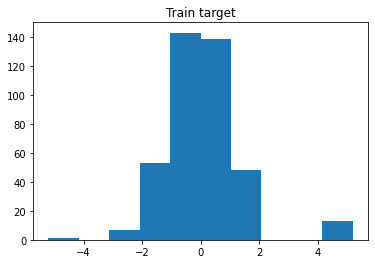

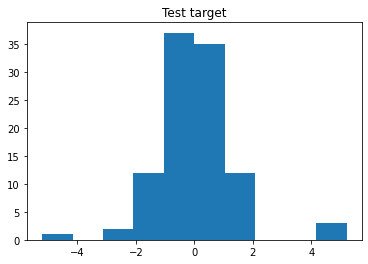

In [38]:
RANDOM_SEED = 42

seed_everything(RANDOM_SEED)

X_train, X_test, y_train, y_test = get_and_process_boston_dataset(random_state=RANDOM_SEED)

visualise_boston(X_train, X_test, y_train, y_test)

# Create Model

In [3]:
model = FFN(
    input_shape=X_train.shape[1], 
    layer_specs=[
        Dense(16, nonlinearity=ReLU),
        Dense(32, nonlinearity=ReLU),
        Dense(1, nonlinearity=Linear)
    ], 
    loss=MSE, 
    reg_coef=0.01
)

## Train Model

In [4]:
trained, history = model.fit(
    train_sample=(X_train, y_train),
    validation_sample=(X_test, y_test),
    optimiser=ConjugateSGDOptimizer(),
    batch_size=32,
    epochs=7_000,
    verbose=False
)

# Predict and Visualise losses

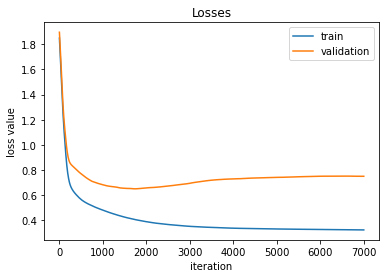

In [5]:
plt.title('Losses')
plt.plot(history['train_loss'], label='train')
plt.plot(history['validation_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.legend()
plt.show()

In [6]:
prediction = trained.predict(X_test)
prediction_train = trained.predict(X_train)

print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 0.6509809548411389
Train MSE: 0.30787698861686386


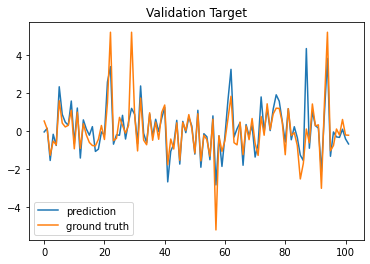

In [7]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

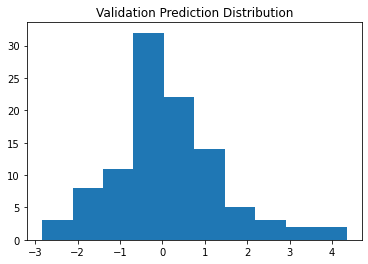

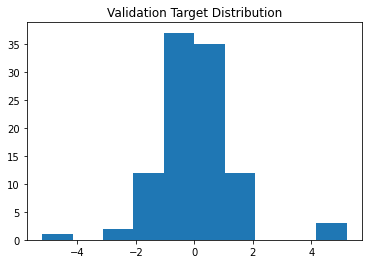

In [8]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()